In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-dataset/Titanic-Dataset.csv


In [2]:
!pip install qiskit qiskit_machine_learning pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 65.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 36.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 114.9 MB/s eta 0:00:0000:0100:01


https://matheuscammarosanohidalgo.medium.com/a-very-simple-variational-quantum-classifier-vqc-64e8ec26589d

# Section 1: Imports & Data Preparation
It loads required libraries and prepares the dataset for training.

In [6]:
import pennylane as qml
from pennylane import numpy as npy  # Use PennyLane's NumPy for quantum operations

import numpy as np  # Standard NumPy for data handling
from pennylane.optimize import AdamOptimizer

import pandas as pd
import math
import pickle
import joblib

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, 
    confusion_matrix, roc_curve, auc, classification_report
)

# Load dataset
df_train = pd.read_csv('/kaggle/input/titanic-dataset/Titanic-Dataset.csv')

# One-hot encode categorical variables
df_train['Pclass'] = df_train['Pclass'].astype(str)
df_train = pd.concat([df_train, pd.get_dummies(df_train[['Pclass', 'Sex', 'Embarked']])], axis=1)

# Fill missing Age values
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())

# Add child feature
df_train['is_child'] = df_train['Age'].map(lambda x: 1 if x < 12 else 0)

# Feature columns
cols_model = ['is_child', 'Pclass_1', 'Pclass_2', 'Sex_female']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df_train[cols_model], df_train['Survived'], test_size=0.10, 
    random_state=42, stratify=df_train['Survived']
)

# Convert to NumPy arrays (standard NumPy)
X_train = np.array(X_train.values)
Y_train = np.array(y_train.values * 2 - np.ones(len(y_train)))
X_test = np.array(X_test.values)
Y_test = np.array(y_test.values * 2 - np.ones(len(y_test)))

print("Data Prepared Successfully ✅")


Data Prepared Successfully ✅


# Section 2: Define Quantum Classifier & Cost Function
This defines the Quantum Model, Cost Function, and Accuracy Function.
Run this cell before training the quantum model.

In [7]:
num_qubits = 4
num_layers = 4
dev = qml.device("default.qubit", wires=num_qubits)

def statepreparation(x):
    qml.BasisEmbedding(x, wires=range(0, num_qubits))

def layer(W):
    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

@qml.qnode(dev, interface="autograd")
def circuit(weights, x):
    statepreparation(x)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    return npy.mean((npy.array(labels) - npy.array(predictions)) ** 2)

def accuracy(labels, predictions):
    return npy.mean(npy.abs(npy.array(labels) - npy.array(predictions)) < 1e-5)

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

print("Quantum Classifier Defined ✅")


Quantum Classifier Defined ✅


# Section 3: Train Quantum Classifier & Save Best Model
This trains the quantum model, applies early stopping, and saves the best model.

In [8]:
npy.random.seed(0)

# Ensure `requires_grad` is applied to PennyLane NumPy objects
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)  # Standard NumPy
weights_init = npy.array(weights_init, requires_grad=True)  # Convert to PennyLane NumPy

bias_init = npy.array(0.0, requires_grad=True)

opt = AdamOptimizer(0.125)
num_it = 70
batch_size = math.floor(len(X_train) / num_it)

patience = 10
best_cost = float('inf')
stagnation_counter = 0

weights = weights_init
bias = bias_init

for it in range(num_it):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]

    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    current_cost = cost(weights, bias, X_train, Y_train)
    predictions = [npy.sign(variational_classifier(weights, bias, x)) for x in X_train]
    acc = accuracy(Y_train, predictions)

    print(f"Iter: {it+1} | Cost: {current_cost:.7f} | Accuracy: {acc:.7f}")

    if current_cost < best_cost:
        best_cost = current_cost
        stagnation_counter = 0
        best_weights = weights
        best_bias = bias
        with open("best_quantum_model.pkl", "wb") as f:
            pickle.dump({"weights": best_weights, "bias": best_bias}, f)
    else:
        stagnation_counter += 1

    if stagnation_counter >= patience:
        print("Early stopping triggered at iteration", it+1)
        break

print("Quantum Model Training Complete & Saved ✅")


Iter: 1 | Cost: 2.3929454 | Accuracy: 0.3121099
Iter: 2 | Cost: 1.8910988 | Accuracy: 0.3121099
Iter: 3 | Cost: 1.3619501 | Accuracy: 0.3133583
Iter: 4 | Cost: 1.0618491 | Accuracy: 0.5243446
Iter: 5 | Cost: 1.0487700 | Accuracy: 0.6167291
Iter: 6 | Cost: 1.0734850 | Accuracy: 0.6167291
Iter: 7 | Cost: 1.0759275 | Accuracy: 0.6167291
Iter: 8 | Cost: 1.0669344 | Accuracy: 0.6167291
Iter: 9 | Cost: 1.0401045 | Accuracy: 0.6167291
Iter: 10 | Cost: 1.0008692 | Accuracy: 0.6167291
Iter: 11 | Cost: 0.9641866 | Accuracy: 0.6167291
Iter: 12 | Cost: 0.9296386 | Accuracy: 0.6167291
Iter: 13 | Cost: 0.8889262 | Accuracy: 0.6167291
Iter: 14 | Cost: 0.8372973 | Accuracy: 0.7203496
Iter: 15 | Cost: 0.7910569 | Accuracy: 0.7203496
Iter: 16 | Cost: 0.7463503 | Accuracy: 0.7815231
Iter: 17 | Cost: 0.7139174 | Accuracy: 0.7902622
Iter: 18 | Cost: 0.6849705 | Accuracy: 0.7902622
Iter: 19 | Cost: 0.6675472 | Accuracy: 0.7902622
Iter: 20 | Cost: 0.6584338 | Accuracy: 0.7902622
Iter: 21 | Cost: 0.6654410 | 

# Section 4: Train & Save Logistic Regression Model

In [9]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
joblib.dump(log_reg, "logistic_regression_model.pkl")

print("Logistic Regression Model Trained & Saved")


Logistic Regression Model Trained & Saved


# Section 5: Load Models & Make Predictions

In [10]:
# Load Quantum Model
with open("best_quantum_model.pkl", "rb") as f:
    saved_model = pickle.load(f)
best_weights = saved_model["weights"]
best_bias = saved_model["bias"]

# Predictions
quantum_preds = [np.sign(variational_classifier(best_weights, best_bias, x)) for x in X_test]
log_reg = joblib.load("logistic_regression_model.pkl")
logistic_preds = log_reg.predict(X_test)

print("Predictions Done")


Predictions Done


# Section 6: Save Predictions as CSV

In [11]:
df_results_quantum = pd.DataFrame({
    'Patient': range(len(Y_test)),
    'Actual': Y_test,
    'Predicted': quantum_preds
})
df_results_quantum.to_csv("quantum_predictions.csv", index=False)

df_results_logistic = pd.DataFrame({
    'Patient': range(len(Y_test)),
    'Actual': y_test,
    'Predicted': logistic_preds
})
df_results_logistic.to_csv("logistic_predictions.csv", index=False)

print("Predictions Saved")


Predictions Saved


# Section 7: Print Confusion Matrix & ROC Curve


Quantum Classification Report:
               precision    recall  f1-score   support

        -1.0       0.72      0.93      0.81        55
         1.0       0.79      0.43      0.56        35

    accuracy                           0.73        90
   macro avg       0.75      0.68      0.68        90
weighted avg       0.75      0.73      0.71        90


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.80        55
           1       0.70      0.66      0.68        35

    accuracy                           0.76        90
   macro avg       0.74      0.74      0.74        90
weighted avg       0.75      0.76      0.75        90



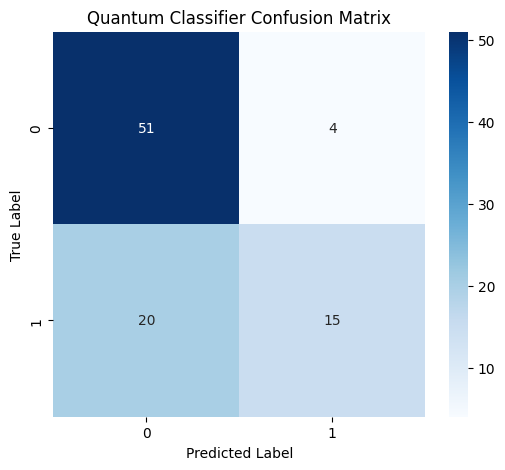

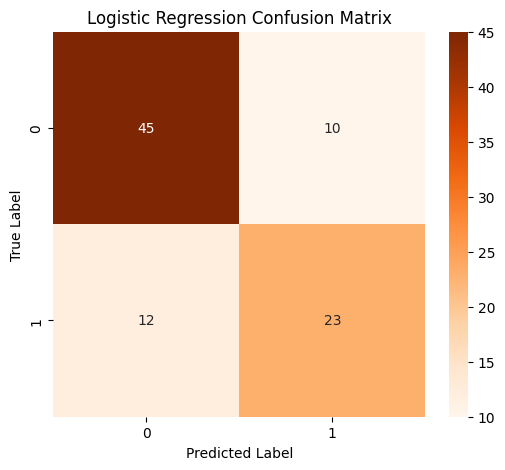


Quantum Confusion Matrix:
 [[51  4]
 [20 15]]

Logistic Regression Confusion Matrix:
 [[45 10]
 [12 23]]


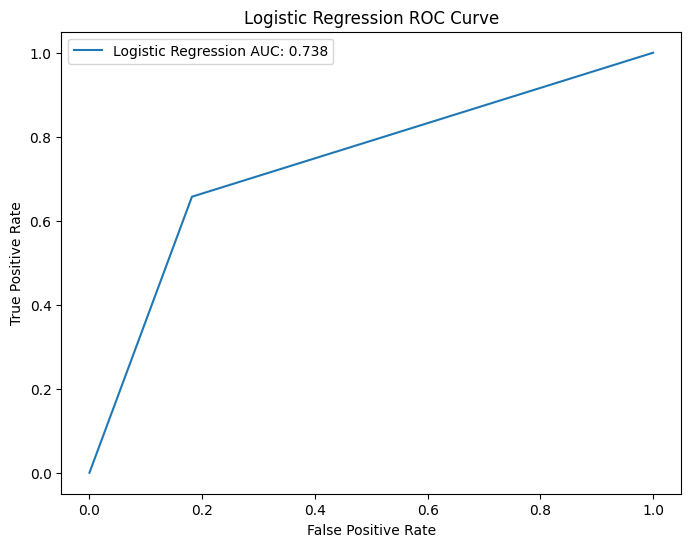

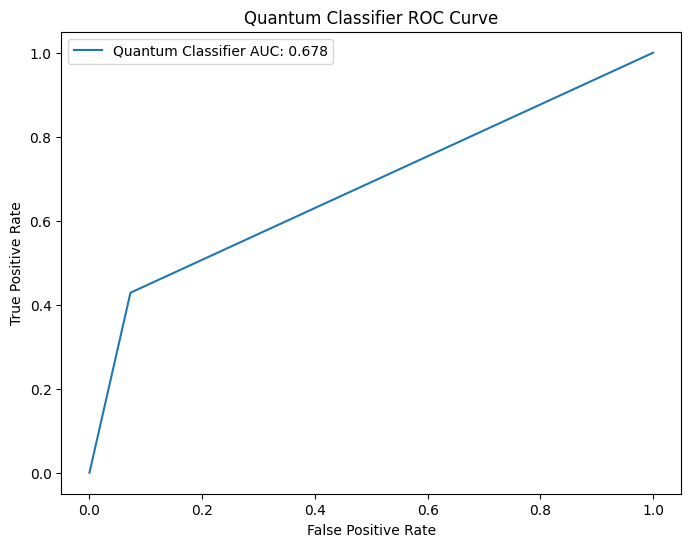

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# **PRINT CLASSIFICATION REPORTS**
print("\nQuantum Classification Report:\n", classification_report(Y_test, quantum_preds))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, logistic_preds))


# Quantum Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(Y_test, quantum_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Quantum Classifier Confusion Matrix")
plt.savefig("quantum_confusion_matrix.png")  # Save the quantum confusion matrix
plt.show()

# Logistic Regression Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, logistic_preds), annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression Confusion Matrix")
plt.savefig("logistic_confusion_matrix.png")  # Save the logistic regression confusion matrix
plt.show()

# **PRINT CONFUSION MATRICES**
print("\nQuantum Confusion Matrix:\n", confusion_matrix(Y_test, quantum_preds))
print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, logistic_preds))

# ROC Curve for Logistic Regression
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, logistic_preds)
plt.plot(fpr, tpr, label="Logistic Regression AUC: {:.3f}".format(auc(fpr, tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.legend()
plt.savefig("logistic_roc_curve.png")  # Save logistic regression ROC curve
plt.show()

# ROC Curve for Quantum Classifier
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(Y_test, quantum_preds)
plt.plot(fpr, tpr, label="Quantum Classifier AUC: {:.3f}".format(auc(fpr, tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Quantum Classifier ROC Curve")
plt.legend()
plt.savefig("quantum_roc_curve.png")  # Save quantum classifier ROC curve
plt.show()
